# Laboratorio 04 - Procesamiento de Lenguaje Natural (NLP)

Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

#### Configuración de GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

### Librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb


import nltk
from nltk.corpus import opinion_lexicon

In [3]:
maxlen = 500
num_words = 50000

### Importación de Datos

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(
    num_words=num_words, 
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)

### Pre-procesamiento

#### Secuenciación y relleno de críticas

In [5]:
X_train = sequence.pad_sequences(X_train, maxlen = maxlen)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen)

#### Extracción de features

##### Longitud de la crítica

In [6]:
train_len = [len(x) for x in X_train]
test_len = [len(x) for x in X_test]

##### Ratio de palabras positivas/negativas

In [7]:
##############################################
#      DESCARGA DE CORPUS DE OPINIONES
# OJO: Solo se descarga una vez
# Descomentar SOLO si no se tiene descargado
# nltk.download('opinion_lexicon')
##############################################

In [8]:
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [9]:
word_index = imdb.get_word_index()
index_to_word = {index: word for word, index in word_index.items()}

In [10]:
# Función para convertir una secuencia de índices a palabras
def decode_review(review):
    return [index_to_word.get(i - 3, '?') for i in review]

In [11]:
# Función para calcular proporción de palabras positivas/negativas
def calculate_word_proportion(review, word_list):
    review_words = decode_review(review)
    count = sum([1 for word in review_words if word in word_list])
    return count / len(review_words) if len(review_words) > 0 else 0

In [12]:
positive_proportions_train = [calculate_word_proportion(x, positive_words) for x in X_train]
negative_proportions_train = [calculate_word_proportion(x, negative_words) for x in X_train]

In [13]:
positive_proportions_test = [calculate_word_proportion(x, positive_words) for x in X_test]
negative_proportions_test = [calculate_word_proportion(x, negative_words) for x in X_test]

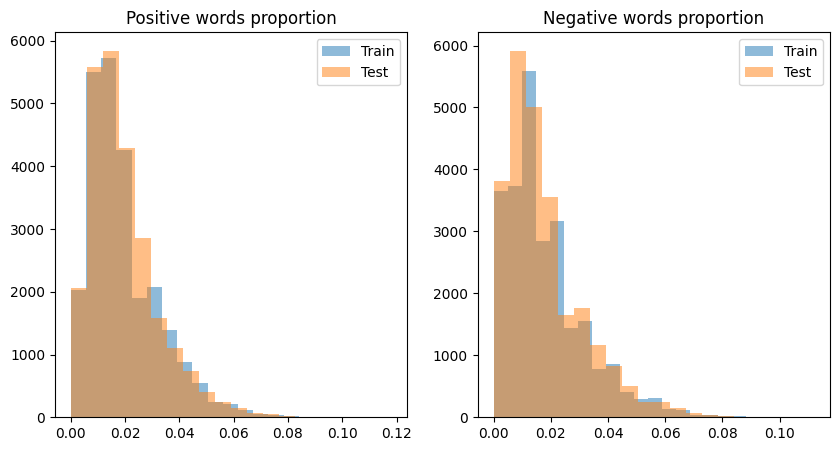

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(positive_proportions_train, bins=20, alpha=0.5, label='Train')
plt.hist(positive_proportions_test, bins=20, alpha=0.5, label='Test')
plt.title('Positive words proportion')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(negative_proportions_train, bins=20, alpha=0.5, label='Train')
plt.hist(negative_proportions_test, bins=20, alpha=0.5, label='Test')
plt.title('Negative words proportion')
plt.legend()

##### Diverisad de palabras

In [15]:
def calculate_lexical_diversity(review):
    review_words = decode_review(review)
    unique_words = set(review_words)
    return len(unique_words) / len(review_words) if len(review_words) > 0 else 0

In [16]:
lexical_diversity_train = [calculate_lexical_diversity(x) for x in X_train]
lexical_diversity_test = [calculate_lexical_diversity(x) for x in X_test]

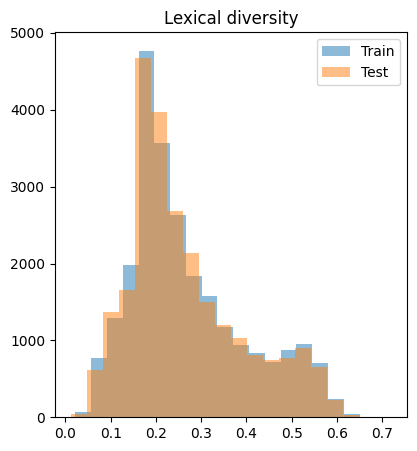

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(lexical_diversity_train, bins=20, alpha=0.5, label='Train')
plt.hist(lexical_diversity_test, bins=20, alpha=0.5, label='Test')
plt.title('Lexical diversity')
plt.legend()

In [18]:
additional_features_train = np.column_stack((positive_proportions_train, negative_proportions_train, train_len, lexical_diversity_train))
additional_features_test = np.column_stack((positive_proportions_test, negative_proportions_test, test_len, lexical_diversity_test))

#### Modelo

In [19]:
embedding_size = 128
dropout_rate = 0.1

In [20]:
# Input para las secuencias de palabras
sequence_input = Input(shape=(maxlen,), name='sequence_input')
embedding_layer = Embedding(num_words, embedding_size)(sequence_input)

# Primera capa LSTM
lstm_layer1 = LSTM(64, return_sequences=True)(embedding_layer)
dropout_layer1 = Dropout(dropout_rate)(lstm_layer1)

# Segunda capa LSTM
lstm_layer2 = LSTM(64)(dropout_layer1)
dropout_layer2 = Dropout(dropout_rate)(lstm_layer2)

# Input para las características adicionales
additional_input = Input(shape=(4,), name='additional_input')

# Concatenar las características adicionales con la salida de LSTM
merged = concatenate([dropout_layer2, additional_input])

# Capa densa
dense_layer = Dense(64, activation='relu')(merged)
dropout_layer3 = Dropout(dropout_rate)(dense_layer)

# Capa de salida
output_layer = Dense(1, activation='sigmoid')(dropout_layer3)

In [21]:
model = Model(inputs=[sequence_input, additional_input], outputs=output_layer)

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 128)     6400000     ['sequence_input[0][0]']         
                                                                                                  
 lstm (LSTM)                    (None, 500, 64)      49408       ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 500, 64)      0           ['lstm[0][0]']                   
                                                                                              

#### Entrenamiento

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
model_save_path = 'sentiment_lstm_model.h5'

In [26]:
checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [28]:
history = model.fit([X_train, additional_features_train], y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=([X_test, additional_features_test], y_test), 
                    verbose=2,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to sentiment_lstm_model.h5
782/782 - 122s - loss: 4.6698 - accuracy: 0.5042 - val_loss: 0.7871 - val_accuracy: 0.5000 - 122s/epoch - 156ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.50000 to 0.78368, saving model to sentiment_lstm_model.h5
782/782 - 118s - loss: 0.7268 - accuracy: 0.5483 - val_loss: 0.4862 - val_accuracy: 0.7837 - 118s/epoch - 150ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.78368 to 0.86296, saving model to sentiment_lstm_model.h5
782/782 - 119s - loss: 0.3668 - accuracy: 0.8522 - val_loss: 0.3560 - val_accuracy: 0.8630 - 119s/epoch - 152ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.86296 to 0.87872, saving model to sentiment_lstm_model.h5
782/782 - 120s - loss: 0.1833 - accuracy: 0.9380 - val_loss: 0.3219 - val_accuracy: 0.8787 - 120s/epoch - 153ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.87872
782/782 - 120s - loss: 0.0922 - accuracy

In [29]:
##############################################
# SI SE TIENE EL MODELO GUARDADO, SE PUEDE
# CARGAR DIRECTAMENTE
# ES DECIR, NO ES NECESARIO ENTRENARLO
##############################################

In [30]:
model = tf.keras.models.load_model(model_save_path)

In [31]:
test_loss, test_accuracy = model.evaluate(
    [X_test, additional_features_test],
    y_test, 
    batch_size=32,
    verbose=2
)

782/782 - 37s - loss: 0.3219 - accuracy: 0.8787 - 37s/epoch - 48ms/step


In [32]:
print(f"Loss en test: {test_loss}")
print(f"Accuracy en test: {test_accuracy}")

Loss en test: 0.32189276814460754
Accuracy en test: 0.8787199854850769
